1/9/2024 v. 0.1

Follow the instructions below:

Define variables 
Check log file

In [1]:
import Bio
from Bio.Seq import Seq
from Bio import SeqIO
import numpy as np
import seqlogo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
import os
from collections import Counter
from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
import re
import math
import random

In [2]:
# Define Variables for Quality and Adaptor Trimming here.

# Quality score cutoff default = 30
Cutoff = 30

# Defining Adaptors 
# 3'-adaptor: MADAP, 4N or Normal
Adaptor_3 = "MADAP" # or "Normal"
# 5'-adaptor = 4N for N4_List_Unique or Normal for TCTA
Adaptor_5 = "4N" # 4N or "Normal"

# Initialize log file dictionary
Log_File = {}
Log_File.update({"Quality Score Cutoff":Cutoff, "3'-Adaptor Sequence":Adaptor_3, "5'-Adaptor":Adaptor_5}) ## fill out all of the initial variables.

In [3]:
#extracting the name of the folder to use as variable, replacing the underscore for a - dash as the fastq files are using that. 
Folder_Name = os.getcwd()

Exp_Name = Folder_Name.split(sep="/")
Exp_Name = Exp_Name[-1]

Corrected_Name = Exp_Name.replace("_", "-")
Corrected_Name = Corrected_Name.upper()

Nice_Name = Corrected_Name[0].upper() + Corrected_Name[1:].lower()
Nice_Name = Nice_Name.replace("-", "_")

Log_File.update({"Folder_Name":Folder_Name, "Corrected_Name":Corrected_Name, "Nice_Name":Nice_Name})

In [4]:
# Get a list of files in the current directory
Folder_Files = os.listdir()

# Filter the files based on the naming convention
File_Matches = [file for file in Folder_Files if file.startswith(Corrected_Name) and file.endswith("L001_R1_001.fastq")]

# Check if any matching files were found
if File_Matches:
    # Assuming we only want the first matching file
    Read_1_File_Name = File_Matches[0]
    
Log_File.update({"Read_1_File_Name":Read_1_File_Name})

In [5]:
# making the VCG comparison list - requires the file to be in the same directory (see copy_VCG.sh)

# Read lines from the file and remove trailing 'p' characters and newline characters
raw_list = [line.strip("p\n") for line in open("VCG_List.txt").readlines()]

# Remove empty strings from the list
clean_list = list(filter(None, raw_list))

# Convert RNA sequences to DNA sequences using Biopython
VCG_DNA_List = [str(Seq(seq).back_transcribe()) for seq in clean_list]

In [6]:
# Making list of all randomized 4 base regions for 5'-adaptor with randomized 3'-end, used for 5' adaptor trimming for 4N and 4N+Splint
# These are the 4 initital bases in Read 1. There are 256.
def DNA(length):
    return ''.join(random.choice("A"*1+"C"*1+"G"*1+"T"*1) for _ in range(length))

N4_List = []
for i in range(2000):
    N4_List.append(DNA(4))

N4_List_Unique = list(set(N4_List))

if Adaptor_5 == "4N":
    motif = N4_List_Unique
    Log_File.update({"5'-adaptor: ":Adaptor_5, "N4 combinations":len(N4_List_Unique)})
elif Adaptor_5 == "Normal":
    motif = "TCTA"
    Log_File.update({"5'-Adaptor: ":Adaptor_5, "5'-Adaptor Sequence":motif})

In [7]:
# Filtering based on quality score - threshold is set above
Low_Qual = []
High_Qual = []
Total_Reads = 0
for record in SeqIO.parse(f"{Read_1_File_Name}", "fastq"): #INPUT READ 1 FILE GOES HERE
    Total_Reads +=1
    Score=record.letter_annotations["phred_quality"] 
    Length_Record = len(Score)

    Add_p = 0

    for i in Score:
        p = 10 ** (-i / 10)       
        Add_p = Add_p + p

    Average_p = Add_p/Length_Record
    Q_P_Bar = -10 * math.log10(Average_p)
    
    if Q_P_Bar < Cutoff: # defining cutoff as q30 for entire read
        Low_Qual.append(record)
    else:
        High_Qual.append(record)
        
        
SeqIO.write(Low_Qual, f"low_quality_{Nice_Name}.fastq", "fastq") # save low quality reads to file
SeqIO.write(High_Qual, f"high_quality_{Nice_Name}.fastq", "fastq") # save high quality reads to file

Percentage_Low_Qual = (len(Low_Qual) / Total_Reads) * 100
Percentage_High_Qual = (len(High_Qual) / Total_Reads) * 100

print("Number of total reads: " + str(Total_Reads))
print("Number of Low Quality reads written out: " + str(len(Low_Qual)) + f" ({Percentage_Low_Qual:.2f}%)")
print("Number of High Quality reads written out: " + str(len(High_Qual)) + f" ({Percentage_High_Qual:.2f}%)")

Log_File.update({"Number of total reads:":str(Total_Reads), 
                 "Number of Low Quality reads written out:":(str(len(Low_Qual)) + f" ({Percentage_Low_Qual:.2f}%)"), 
                 "Number of High Quality reads written out:":(str(len(High_Qual)) + f" ({Percentage_High_Qual:.2f}%)")})

Number of total reads: 1542339
Number of Low Quality reads written out: 760861 (49.33%)
Number of High Quality reads written out: 781478 (50.67%)


In [8]:
# Adaptor trimming - both adaptors are defined above
Pre_Trim = []

for record in SeqIO.parse(f"high_quality_{Nice_Name}.fastq", "fastq"): # leave lowercase for now 
    Pre_Trim.append(str(record.seq))
print("Number of High Quality reads read in: "+str(len(Pre_Trim)))
#Log_File.update({"Adaptor Trimming, Number of High Quality reads read in: ":str(len(Pre_Trim)), 
                 #"Matches reads from quality trimming:":(len(Pre_Trim)==len(High_Qual))})

#motif = N4_List_Unique adaptor is 4N random end of regular 5 adap
motif2 = "AGATCGGAAGAGCACACGTCT" # adaptor for OPT_374 is NNNNAGATCGCAANNNNCTAGATCGGAAGAGCACACGTCTAAdUGAATddC trim everything to the left of it first

#print("5' adaptor: "+str(motif))
#print("3' adaptor: "+str(motif2))

pattern1 = re.compile("|".join(motif))
pattern2 = re.compile(motif2)

matched1 = []
matched2 = []
unmatched = []
trimmed = []

for seq in Pre_Trim:
    adaptor1_range = seq[0:4]
    adaptor2_range = seq[4:]
    if pattern1.search(adaptor1_range):
        matched1.append(seq)
        if pattern2.search(adaptor2_range):
            matched2.append(seq)
            start = pattern1.search(adaptor1_range).end()
            end = pattern2.search(seq).start() # look closer here
            trimmed.append(seq[start:end])           
    else:
        unmatched.append(seq)        
            #print(seq) 

#Length selection
too_long = []
too_short = []
correct_len = []
empty = []

for i in trimmed:
    if len(i) > 35:
        too_long.append(i)
    elif len(i) < 2:
        too_short.append(i)
    elif i == "":
        empty.append(i)
    else:
        correct_len.append(i)

remove_N = []        
        
for i in correct_len:
    remove_N.append(i[:-4])

Number of High Quality reads read in: 781478


In [9]:
print("Total input reads: "+str(len(Pre_Trim)))
print("Number of seqs with First adaptor: "+str(len(matched1))+" -- "+str(math.floor(len(matched1)/len(Pre_Trim)*100))+"% of total input")
print("Number of seqs with adaptors: "+str(len(matched2))+" -- "+str(math.floor(len(matched2)/len(Pre_Trim)*100))+"% of total input")
print("Number of seqs with adaptors: "+str(len(trimmed))+" -- "+str(math.floor(len(trimmed)/len(Pre_Trim)*100))+"% of total input")
print("Number of seqs WITHOUT adaptors: "+str(len(unmatched))+" -- "+str(math.floor(len(unmatched)/len(Pre_Trim)*100))+"% of total input")
print("-----------------------------"+"\n")
#Length Trimming
print("Length Trimming"+ "\n")
print("Total input reads: "+str(len(trimmed)))
print("Number of seqs that were too long: "+str(len(too_long))+" -- "+str(math.floor(len(too_long)/len(trimmed)*100))+"% of total input")
print("Number of seqs that were too short: "+str(len(too_short))+" -- "+str(math.floor(len(too_short)/len(trimmed)*100))+"% of total input")
print("Number of seqs that were of correct length: "+str(len(correct_len))+" -- "+str(math.floor(len(correct_len)/len(trimmed)*100))+"% of total input")
print("Number of adaptor dimers: "+str(len(empty))+" -- "+str(math.floor(len(empty)/len(correct_len)*100))+"% of total input")

# unique sequences after length trim
unique_seqs = set(remove_N)
print("Number of unique Sequences present: "+str(len(unique_seqs))+" -- "+str(math.floor(len(unique_seqs)/len(Pre_Trim)*100))+"% of total input")
print("Number of unique Sequences present: "+str(len(unique_seqs))+" -- "+str(math.floor(len(unique_seqs)/len(trimmed)*100))+"% of total trimmed")
print("Number of unique Sequences present: "+str(len(unique_seqs))+" -- "+str(math.floor(len(unique_seqs)/len(correct_len)*100))+"% of total correct length")

#sequences in the VCG
in_VCG = set(remove_N).intersection(set(VCG_DNA_List))
print("Number of VCG Sequences present: "+str(len(list(in_VCG)))+" out of 247")
print(list(in_VCG)[:10])

Total input reads: 781478
Number of seqs with First adaptor: 781478 -- 100% of total input
Number of seqs with adaptors: 662343 -- 84% of total input
Number of seqs with adaptors: 662343 -- 84% of total input
Number of seqs WITHOUT adaptors: 0 -- 0% of total input
-----------------------------

Length Trimming

Total input reads: 662343
Number of seqs that were too long: 1419 -- 0% of total input
Number of seqs that were too short: 1722 -- 0% of total input
Number of seqs that were of correct length: 659202 -- 99% of total input
Number of adaptor dimers: 0 -- 0% of total input
Number of unique Sequences present: 300082 -- 38% of total input
Number of unique Sequences present: 300082 -- 45% of total trimmed
Number of unique Sequences present: 300082 -- 45% of total correct length
Number of VCG Sequences present: 245 out of 247
['CACGC', 'GGTGA', 'TGATGCG', 'ACACGCA', 'CACACGCAT', 'TCACCACACGCA', 'CA', 'ACG', 'TGCGT', 'ACACGCATC']


In [10]:
dist_4N = []

motif = N4_List_Unique
motif2 = "AGATCGGAAGAGCACACGTCT"
          #NNNNNNGAAGAGCACACGTCT

pattern1 = re.compile("|".join(motif))
pattern2 = re.compile(motif2)

for i in matched2:
    adaptor1_range = i[0:4]
    adaptor2_range = i[4:]
    start = pattern1.search(adaptor1_range).end()
    end = pattern2.search(i).start() 
    dist_4N.append(i[:start]+"_"+i[start:end]+"-"+i[end:])

In [11]:
def reverse_complement(seq):
    BioSeq = Seq(seq)
    return str(BioSeq.reverse_complement())

In [12]:
df_4N = pd.DataFrame({"Seq":dist_4N})

In [13]:
df_4N.to_csv(f"{Nice_Name}_4N.csv.gz",index=False, compression="gzip")

In [14]:
df_4N = pd.read_csv(f"{Nice_Name}_4N.csv.gz")
df_4N["5_Adap"] = df_4N["Seq"].apply(lambda x: x[0:4]) # slicing the 4 base end of the 5' adaptor - 
df_4N["Less_3"] = df_4N["Seq"].apply(lambda x: x.split("-")[0]) # split on first "-" and everything before - just removes 3-adap
df_4N["Spacer"] = df_4N["Less_3"].apply(lambda x: x[-2:]) # slice final two bases - should be "CT"
df_4N["Rand_4"] = df_4N["Less_3"].apply(lambda x: x[-6:-2]) # slice backwards from -2 to -6 should be 4N region
df_4N["MADAP_Code"] = df_4N["Less_3"].apply(lambda x: x[-9:-6]) # slice from -6 to -9 after random region - should be "CAA" for MADAP1
df_4N["Bind_6"] = df_4N["Less_3"].apply(lambda x: x[-15:-9]) # slice from -9 to -15 after coded region - should be binding/constant region "AGATCG" for MADAP1
df_4N["4N"] = df_4N["Less_3"].apply(lambda x: x[-19:-15]) # slice from -15 to -19 after binding region - randomized junction region "NNNN" for MADAP1
df_4N["Pre_VCG"] = df_4N["Less_3"].apply(lambda x: x[:-19]) # slice everything -19 should be VCG seq + 4N from 5_Adap
df_4N["VCG"] = df_4N["Pre_VCG"].apply(lambda x: x[5:]) # split Pre_VCG on "_" and take second part, should be VCG seq
df_4N["VCG_Len"] = df_4N["VCG"].apply(lambda x: len(x))
df_4N["3_Adap"] = df_4N["Seq"].apply(lambda x: x[5:].split("-")[1][:21]) # split on first "-" and take next 21 characters
Log_File.update({"No. of reads with adaptors":df_4N.shape[0]})
df_4N

,Seq,5_Adap,Less_3,Spacer,Rand_4,MADAP_Code,Bind_6,4N,Pre_VCG,VCG,VCG_Len,3_Adap
0,TTTA_ACCGAGATCGGTTCGAACT-AGATCGGAAGAGCACACGTCT...,TTTA,TTTA_ACCGAGATCGGTTCGAACT,CT,CGAA,GTT,AGATCG,ACCG,TTTA_,,0,AGATCGGAAGAGCACACGTCT
1,CTTA_AGTGAGATCGGTTTTATCT-AGATCGGAAGAGCACACGTCT...,CTTA,CTTA_AGTGAGATCGGTTTTATCT,CT,TTAT,GTT,AGATCG,AGTG,CTTA_,,0,AGATCGGAAGAGCACACGTCT
2,GCAC_CCGCAGATGCTCGCAATGATCT-AGATCGGAAGAGCACACG...,GCAC,GCAC_CCGCAGATGCTCGCAATGATCT,CT,TGAT,CAA,TGCTCG,CAGA,GCAC_CCG,CCG,3,AGATCGGAAGAGCACACGTCT
3,GAAT_CACGCATCCAAGATCGCAAAGGTCT-AGATCGGAAGAGCAC...,GAAT,GAAT_CACGCATCCAAGATCGCAAAGGTCT,CT,AGGT,CAA,AGATCG,TCCA,GAAT_CACGCA,CACGCA,6,AGATCGGAAGAGCACACGTCT
4,TTCA_CACACGTGCAGATCGCAATGGCCT-AGATCGGAAGAGCACA...,TTCA,TTCA_CACACGTGCAGATCGCAATGGCCT,CT,TGGC,CAA,AGATCG,GTGC,TTCA_CACAC,CACAC,5,AGATCGGAAGAGCACACGTCT
...,...,...,...,...,...,...,...,...,...,...,...,...
662338,TTGT_ATCAAGATCGCAAGATCCT-AGATCGGAAGAGCACACGTCT...,TTGT,TTGT_ATCAAGATCGCAAGATCCT,CT,GATC,CAA,AGATCG,ATCA,TTGT_,,0,AGATCGGAAGAGCACACGTCT
662339,GCGG_GCATCACCACAGAAGATCGGTTGGGGCT-AGATCGGAAGAG...,GCGG,GCGG_GCATCACCACAGAAGATCGGTTGGGGCT,CT,GGGG,GTT,AGATCG,CAGA,GCGG_GCATCACCA,GCATCACCA,9,AGATCGGAAGAGCACACGTCT
662340,AAGC_AAGATCGGTTGTGCCT-AGATCGGAAGAGCACACGTCTGAA...,AAGC,AAGC_AAGATCGGTTGTGCCT,CT,GTGC,GTT,AGATCG,GC_A,AA,,0,AGATCGGAAGAGCACACGTCT
662341,TAGG_TTGTAGTGTCCT-AGATCGGAAGAGCACACGTCTGAACTCC...,TAGG,TAGG_TTGTAGTGTCCT,CT,TGTC,TAG,GG_TTG,TA,,,0,AGATCGGAAGAGCACACGTCT


In [15]:
df_4N_reduced = df_4N.query("VCG_Len != 0")
Log_File.update({"No. of reads with 'VCG' Length > 0":df_4N_reduced.shape[0]})
df_4N_reduced

,Seq,5_Adap,Less_3,Spacer,Rand_4,MADAP_Code,Bind_6,4N,Pre_VCG,VCG,VCG_Len,3_Adap
2,GCAC_CCGCAGATGCTCGCAATGATCT-AGATCGGAAGAGCACACG...,GCAC,GCAC_CCGCAGATGCTCGCAATGATCT,CT,TGAT,CAA,TGCTCG,CAGA,GCAC_CCG,CCG,3,AGATCGGAAGAGCACACGTCT
3,GAAT_CACGCATCCAAGATCGCAAAGGTCT-AGATCGGAAGAGCAC...,GAAT,GAAT_CACGCATCCAAGATCGCAAAGGTCT,CT,AGGT,CAA,AGATCG,TCCA,GAAT_CACGCA,CACGCA,6,AGATCGGAAGAGCACACGTCT
4,TTCA_CACACGTGCAGATCGCAATGGCCT-AGATCGGAAGAGCACA...,TTCA,TTCA_CACACGTGCAGATCGCAATGGCCT,CT,TGGC,CAA,AGATCG,GTGC,TTCA_CACAC,CACAC,5,AGATCGGAAGAGCACACGTCT
5,AGGC_GGACAGATCGGTTTTGGCCT-AGATCGGAAGAGCACACGTC...,AGGC,AGGC_GGACAGATCGGTTTTGGCCT,CT,TGGC,TTT,GATCGG,GACA,AGGC_G,G,1,AGATCGGAAGAGCACACGTCT
6,TTGC_TGGTGATGCGTCATAAGATCGCAATTTACT-AGATCGGAAG...,TTGC,TTGC_TGGTGATGCGTCATAAGATCGCAATTTACT,CT,TTTA,CAA,AGATCG,CATA,TTGC_TGGTGATGCGT,TGGTGATGCGT,11,AGATCGGAAGAGCACACGTCT
...,...,...,...,...,...,...,...,...,...,...,...,...
662326,TACT_CACGATATAGATCGCAAAGGATCT-AGATCGGAAGAGCACA...,TACT,TACT_CACGATATAGATCGCAAAGGATCT,CT,GGAT,AAA,GATCGC,TATA,TACT_CACGA,CACGA,5,AGATCGGAAGAGCACACGTCT
662328,TGGG_ACACGCATATAACAGATCGCAATATACT-AGATCGGAAGAG...,TGGG,TGGG_ACACGCATATAACAGATCGCAATATACT,CT,TATA,CAA,AGATCG,TAAC,TGGG_ACACGCATA,ACACGCATA,9,AGATCGGAAGAGCACACGTCT
662330,AGGC_ATGCGTGTGGTGAGATCAGATCGCAATATTCT-AGATCGGA...,AGGC,AGGC_ATGCGTGTGGTGAGATCAGATCGCAATATTCT,CT,TATT,CAA,AGATCG,GATC,AGGC_ATGCGTGTGGTGA,ATGCGTGTGGTGA,13,AGATCGGAAGAGCACACGTCT
662335,TTAA_ACACGTTAAGATCGCAAAGGACT-AGATCGGAAGAGCACAC...,TTAA,TTAA_ACACGTTAAGATCGCAAAGGACT,CT,AGGA,CAA,AGATCG,GTTA,TTAA_ACAC,ACAC,4,AGATCGGAAGAGCACACGTCT


In [16]:
df_4N_VCG = df_4N_reduced.query("VCG in @VCG_DNA_List")
Log_File.update({"No. of reads in VCG":df_4N_VCG.shape[0]})
df_4N_VCG

,Seq,5_Adap,Less_3,Spacer,Rand_4,MADAP_Code,Bind_6,4N,Pre_VCG,VCG,VCG_Len,3_Adap
3,GAAT_CACGCATCCAAGATCGCAAAGGTCT-AGATCGGAAGAGCAC...,GAAT,GAAT_CACGCATCCAAGATCGCAAAGGTCT,CT,AGGT,CAA,AGATCG,TCCA,GAAT_CACGCA,CACGCA,6,AGATCGGAAGAGCACACGTCT
4,TTCA_CACACGTGCAGATCGCAATGGCCT-AGATCGGAAGAGCACA...,TTCA,TTCA_CACACGTGCAGATCGCAATGGCCT,CT,TGGC,CAA,AGATCG,GTGC,TTCA_CACAC,CACAC,5,AGATCGGAAGAGCACACGTCT
6,TTGC_TGGTGATGCGTCATAAGATCGCAATTTACT-AGATCGGAAG...,TTGC,TTGC_TGGTGATGCGTCATAAGATCGCAATTTACT,CT,TTTA,CAA,AGATCG,CATA,TTGC_TGGTGATGCGT,TGGTGATGCGT,11,AGATCGGAAGAGCACACGTCT
7,AAGG_CGTGGGCGAGATCGGTTCTAACT-AGATCGGAAGAGCACAC...,AAGG,AAGG_CGTGGGCGAGATCGGTTCTAACT,CT,CTAA,GTT,AGATCG,GGCG,AAGG_CGTG,CGTG,4,AGATCGGAAGAGCACACGTCT
10,TAAT_CACGCATCTATAGATCGCAAGACTCT-AGATCGGAAGAGCA...,TAAT,TAAT_CACGCATCTATAGATCGCAAGACTCT,CT,GACT,CAA,AGATCG,CTAT,TAAT_CACGCAT,CACGCAT,7,AGATCGGAAGAGCACACGTCT
...,...,...,...,...,...,...,...,...,...,...,...,...
662315,CTTT_CGTGTGCGGAGATCGCAAATTACT-AGATCGGAAGAGCACA...,CTTT,CTTT_CGTGTGCGGAGATCGCAAATTACT,CT,ATTA,CAA,AGATCG,GCGG,CTTT_CGTGT,CGTGT,5,AGATCGGAAGAGCACACGTCT
662316,TCGC_GTGTGGTTCATAGATCGCAATAGCCT-AGATCGGAAGAGCA...,TCGC,TCGC_GTGTGGTTCATAGATCGCAATAGCCT,CT,TAGC,CAA,AGATCG,TCAT,TCGC_GTGTGGT,GTGTGGT,7,AGATCGGAAGAGCACACGTCT
662320,TAGG_GCATCACCAATATAGATCGCAAAAATCT-AGATCGGAAGAG...,TAGG,TAGG_GCATCACCAATATAGATCGCAAAAATCT,CT,AAAT,CAA,AGATCG,ATAT,TAGG_GCATCACCA,GCATCACCA,9,AGATCGGAAGAGCACACGTCT
662335,TTAA_ACACGTTAAGATCGCAAAGGACT-AGATCGGAAGAGCACAC...,TTAA,TTAA_ACACGTTAAGATCGCAAAGGACT,CT,AGGA,CAA,AGATCG,GTTA,TTAA_ACAC,ACAC,4,AGATCGGAAGAGCACACGTCT


In [17]:
df_4N_VCG_group = df_4N_VCG.groupby(by=["VCG_Len", "VCG"], as_index=False).count()
df_4N_VCG_group = df_4N_VCG_group[["VCG_Len", "VCG", "Seq"]]
df_4N_VCG_group

,VCG_Len,VCG,Seq
0,2,AC,1265
1,2,AT,760
2,2,CA,1081
3,2,CC,597
4,2,CG,1071
...,...,...,...
242,12,TCACCACACGCA,483
243,12,TGATGCGTGTGG,555
244,12,TGCGTGTGGTGA,553
245,12,TGGTGATGCGTG,582


In [18]:
norm_factor = int(df_4N_VCG_group.Seq.sum())/247
Log_File.update({"Normalization Factor: ":str((round(norm_factor, 2)))})
norm_factor

805.2267206477733

In [19]:
df_4N_VCG_group["Norm_Reads"] = df_4N_VCG_group.Seq.apply(lambda x: (round(x/norm_factor, 2)))
#df_4N_VCG_group["Norm_Reads"] = df_4N_VCG_group.Seq.apply(lambda x: (round(x/norm_factor, 2)))
df_4N_VCG_group

,VCG_Len,VCG,Seq,Norm_Reads
0,2,AC,1265,1.57
1,2,AT,760,0.94
2,2,CA,1081,1.34
3,2,CC,597,0.74
4,2,CG,1071,1.33
...,...,...,...,...
242,12,TCACCACACGCA,483,0.60
243,12,TGATGCGTGTGG,555,0.69
244,12,TGCGTGTGGTGA,553,0.69
245,12,TGGTGATGCGTG,582,0.72


In [20]:
Top_5_Seqs_Norm = df_4N_VCG_group.sort_values(by="Norm_Reads", ascending=False).head(5)
Top_5_Seqs_Norm_Tuple = list(Top_5_Seqs_Norm[['VCG', 'Norm_Reads']].itertuples(index=False, name=None))
Log_File.update({"Top 5 Sequences:":Top_5_Seqs_Norm_Tuple})
Top_5_Seqs_Norm_Tuple

[('GTG', 2.78), ('ACGCA', 2.01), ('GT', 1.86), ('CGTGT', 1.85), ('CAC', 1.83)]

In [21]:
Bottom_5_Seqs_Norm = df_4N_VCG_group.sort_values(by="Norm_Reads", ascending=True).head(5)
Bottom_5_Seqs_Norm_Tuple = list(Bottom_5_Seqs_Norm[['VCG', 'Norm_Reads']].itertuples(index=False, name=None))
Log_File.update({"Bottom 5 Sequences:":Bottom_5_Seqs_Norm_Tuple})
Bottom_5_Seqs_Norm_Tuple

[('GGTGATGCGTGT', 0.31),
 ('GCGTGTGGTGAT', 0.37),
 ('GGTGATGCGTG', 0.4),
 ('GCGTGTGGTG', 0.43),
 ('TCA', 0.44)]

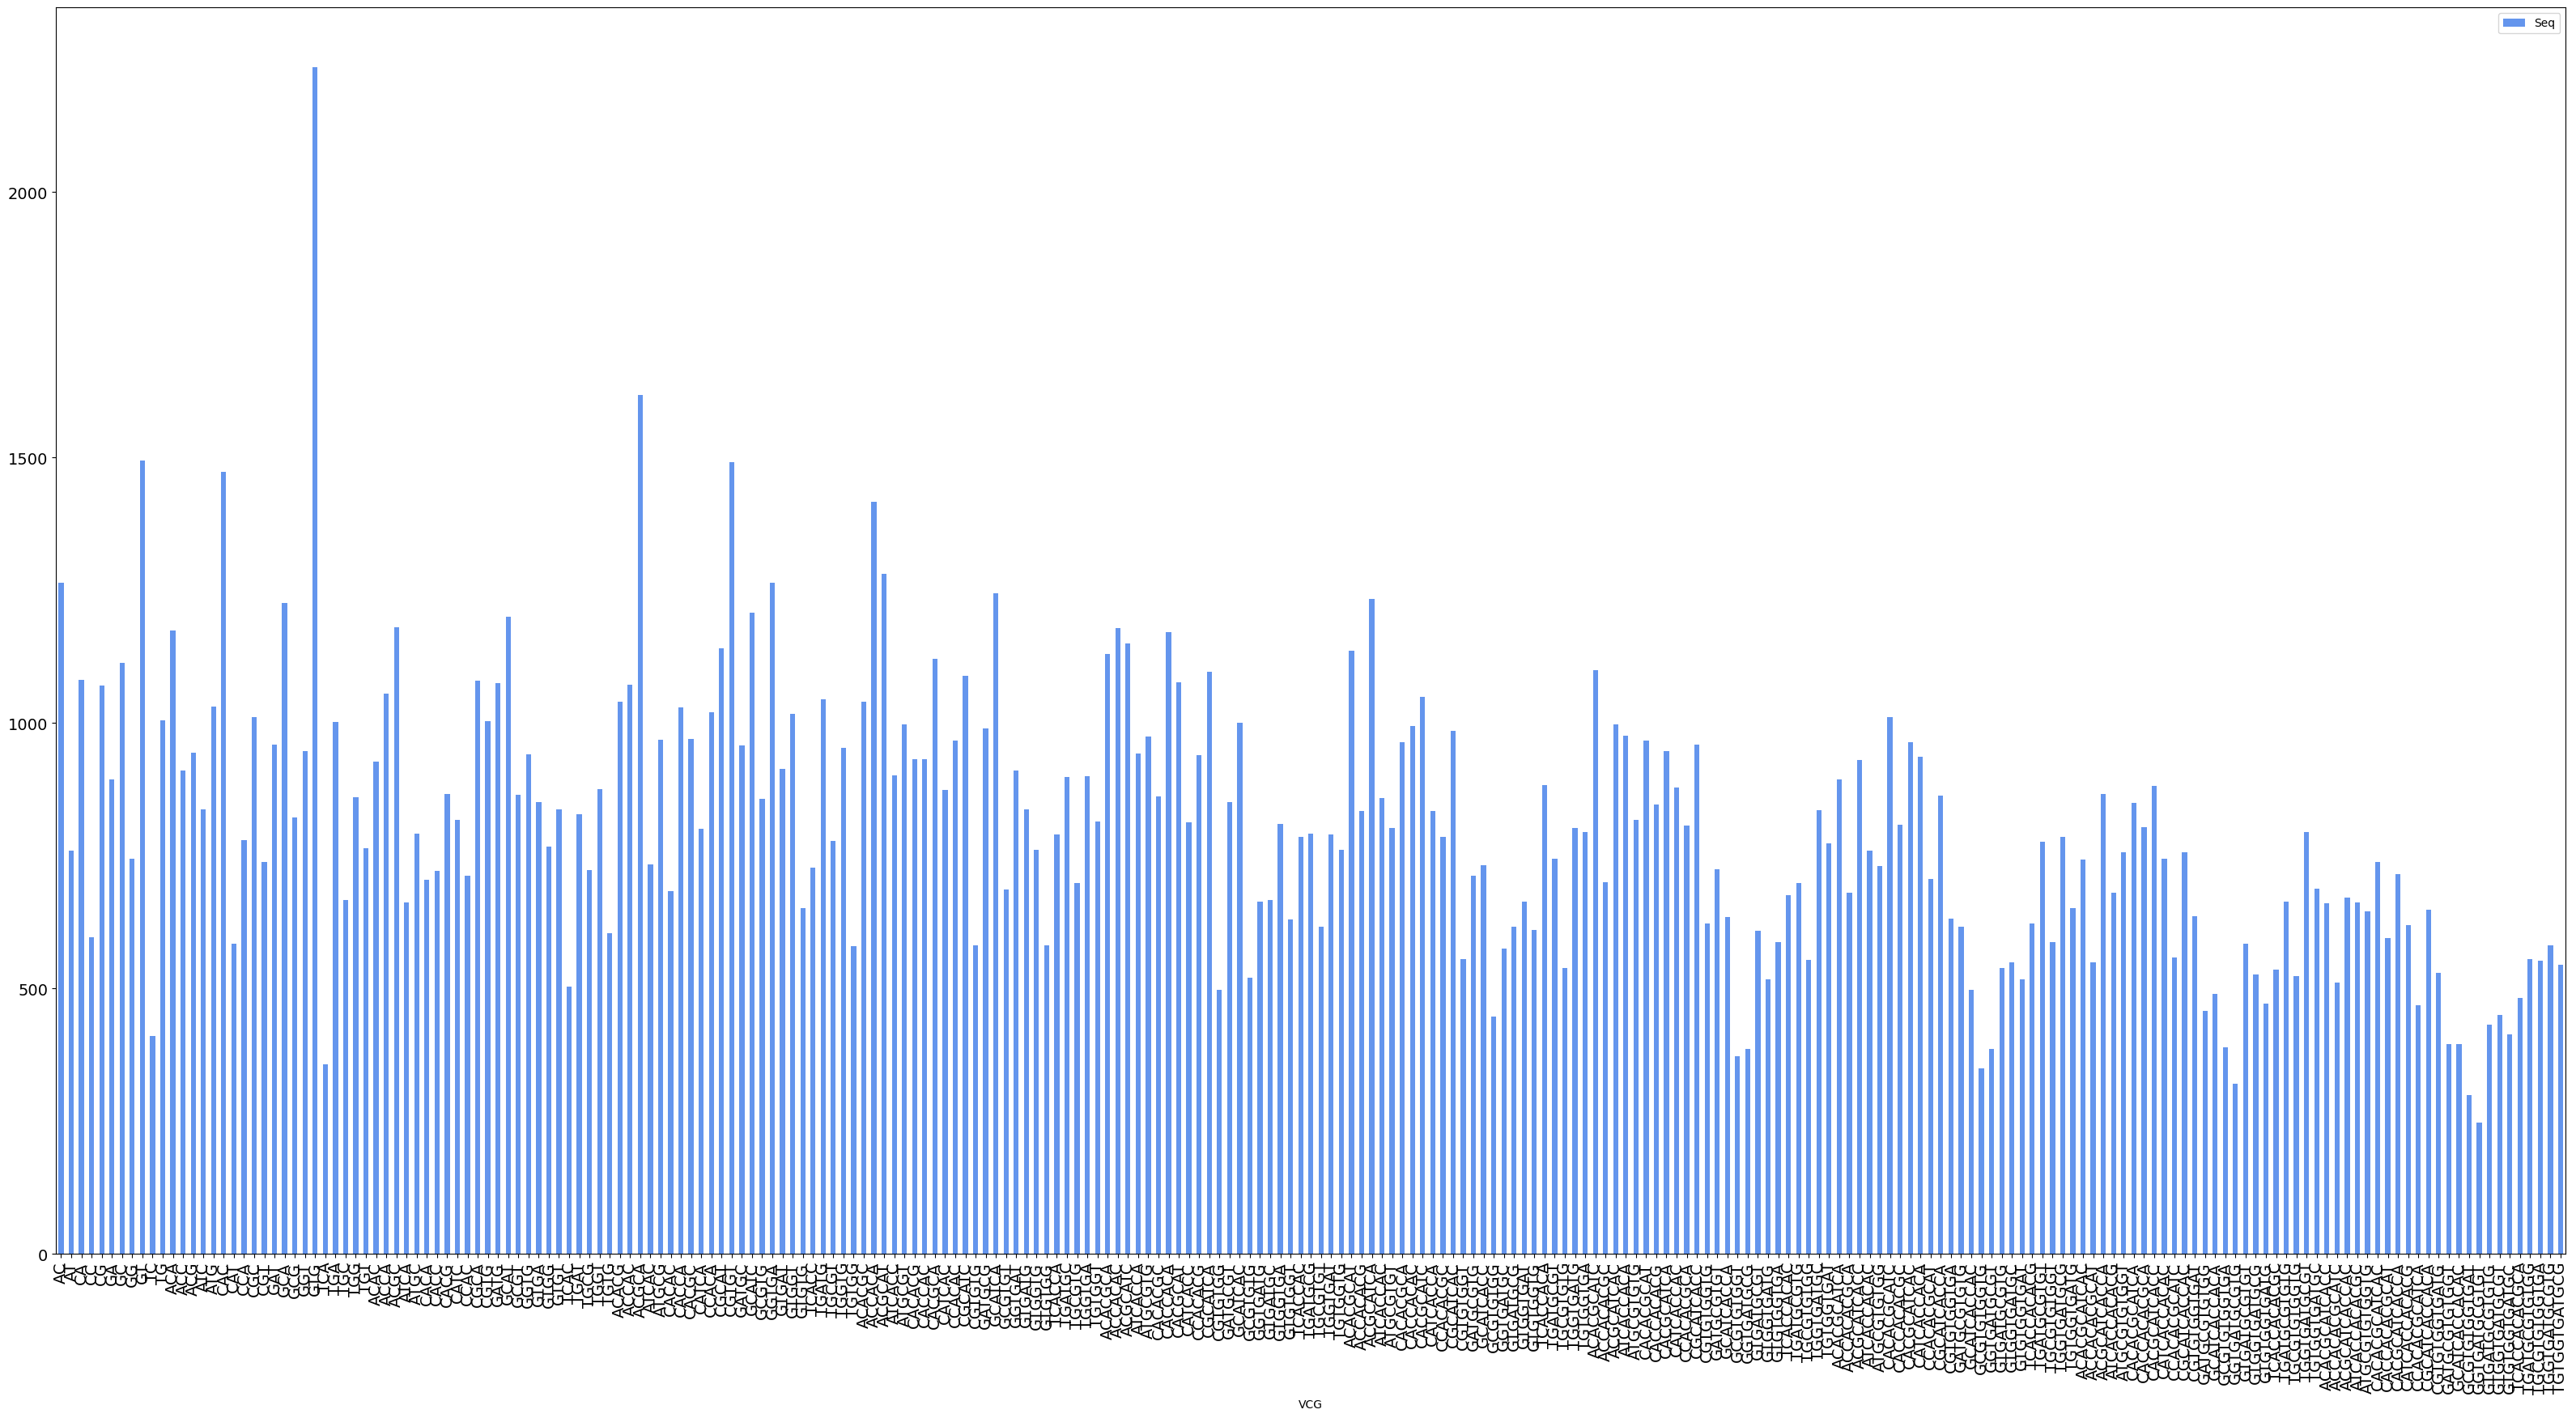

In [22]:
ax = df_4N_VCG_group.plot.bar(x="VCG", y="Seq", color="cornflowerblue",  rot=90, figsize=(40,20), fontsize=14)

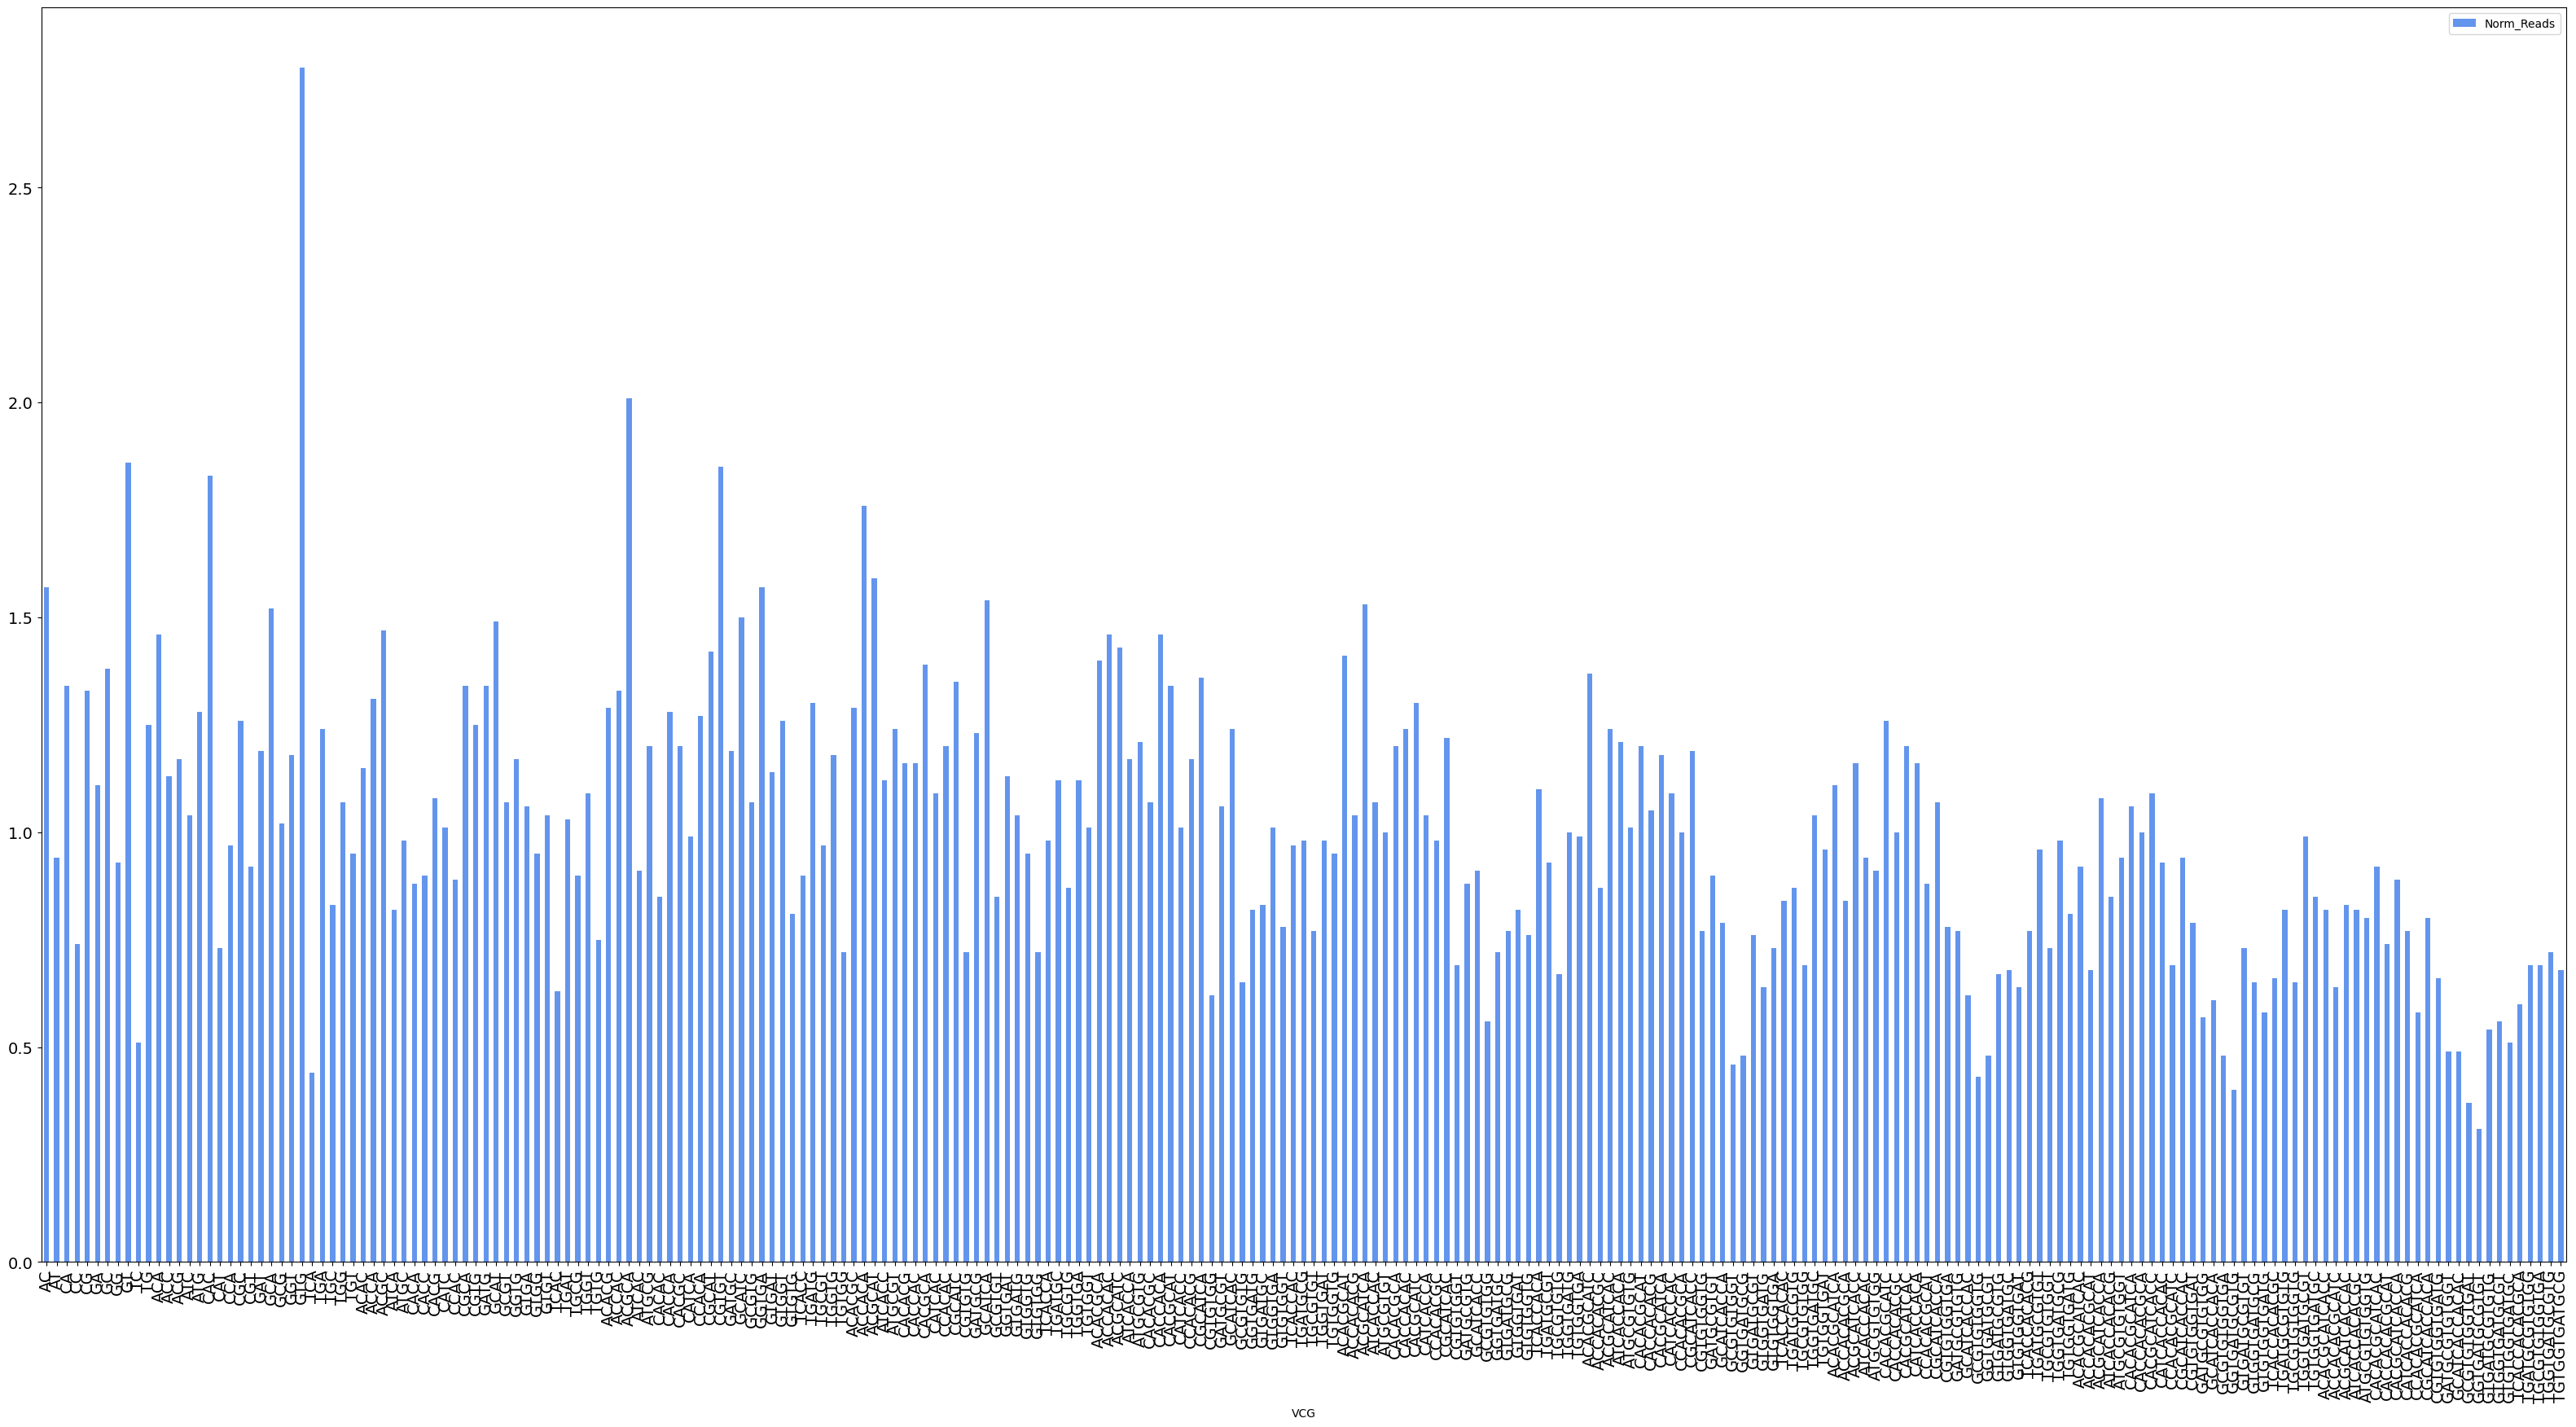

In [23]:
ax = df_4N_VCG_group.plot.bar(x="VCG", y="Norm_Reads", color="cornflowerblue",  rot=90, figsize=(40,20), fontsize=14)
plt.savefig("All_VCG_bar_plot.svg", format="svg", bbox_inches="tight")
plt.show()

In [24]:
# Saving Normalised VCG counts to csv for comparison
df_4N_VCG_group.to_csv(f"{Nice_Name}_Norm.csv",index=False)

### Graphs

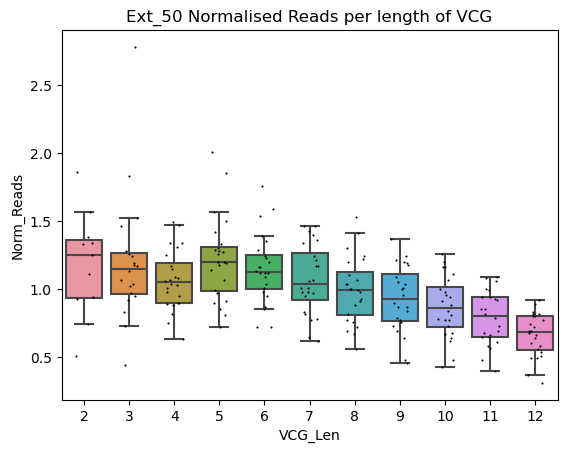

In [25]:
sns.boxplot(x="VCG_Len", y="Norm_Reads", data=df_4N_VCG_group, orient="v", whis=True, fliersize=0.0)
sns.stripplot(x="VCG_Len", y="Norm_Reads", data=df_4N_VCG_group, color="black", jitter=0.2, size=1.5)
#ax.set(ylabel="Test", yticks=[0,1,2])
plt.title(f"{Nice_Name}"+" Normalised Reads per length of VCG")
plt.savefig(f"{Nice_Name}_Norm_Reads_Bar.svg", format="svg", bbox_inches="tight")
plt.show()

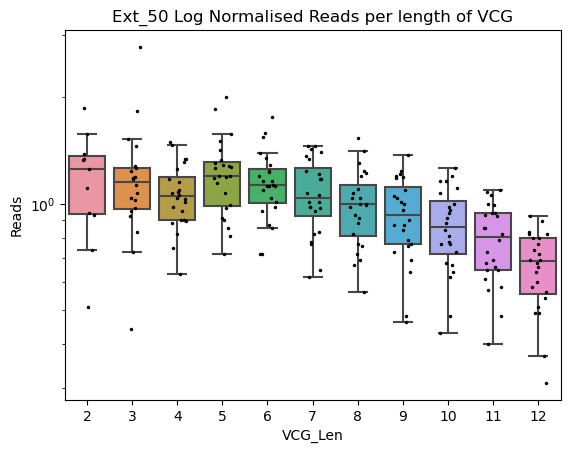

In [26]:
sns.boxplot(x="VCG_Len", y="Norm_Reads", data=df_4N_VCG_group, orient="v", whis=True, fliersize=0.0, )
sns.stripplot(x="VCG_Len", y="Norm_Reads", data=df_4N_VCG_group, color="black", jitter=0.2, size=2.5)
plt.yscale('log')
plt.xticks()
plt.title(f"{Nice_Name}"+" Log Normalised Reads per length of VCG")
#plt.yticks(ticks=[0.001, 0.01, 0.1, 0.5, 1, 2, 5])
plt.ylabel("Reads")
plt.savefig(f"{Nice_Name}_Log_Norm_Reads_Bar.svg", format="svg", bbox_inches="tight")
plt.show()

In [27]:
# Writing Log_File to txt
with open('Log_File.txt', 'w') as file:
    # Iterate over dictionary items and write them to the file
    for key, value in Log_File.items():
        file.write(f"{key}: {value}\n")